In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xgboost as xgb
import optuna
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statistics import mean

calendrier_challenge = pd.read_parquet("calendrier_challenge.parquet")
questionnaire = pd.read_parquet("questionnaire.parquet")
consos_challenge = pd.read_parquet("consos_challenge.parquet")
temperatures = pd.read_parquet("temperatures.parquet")

min_date = datetime.datetime(2009,7,15)
max_date=datetime.datetime(2011,1,1)
all_clients = list(set(questionnaire["id_client"]))
day = datetime.datetime(2011,1,2)-datetime.datetime(2011,1,1)
conso_client = consos_challenge.pivot_table(index='horodate', columns='id_client', values='puissance_W', aggfunc='sum')
print(len(all_clients))

615


In [2]:
# Prediction will be made between date 2 and date 3
date1 = datetime.datetime(2010,11,21)
date2 = datetime.datetime.strptime('2010-11-22 18:00:00', '%Y-%m-%d %H:%M:%S')
date3 = datetime.datetime.strptime('2010-11-22 21:00:00', '%Y-%m-%d %H:%M:%S')
date4 = datetime.datetime(2010, 11, 23)

In [3]:
conso_client

id_client,1005,1015,1047,1058,1067,1077,1082,1091,1108,1110,...,7359,7364,7370,7394,7398,7411,7412,7417,7431,7440
horodate,,,,,,,,,,,,,,,,,,,,,
2009-07-15 00:00:00,0.177,0.275,0.251,0.225,0.155,0.208,0.456,0.615,0.497,0.481,...,0.050,0.182,0.045,0.210,0.189,0.228,0.281,0.120,0.166,0.304
2009-07-15 00:30:00,0.172,0.147,0.118,0.116,0.112,0.114,0.369,0.349,0.571,0.340,...,0.096,0.066,0.071,0.158,0.111,0.244,0.590,0.120,0.069,0.188
2009-07-15 01:00:00,0.152,0.194,1.184,0.190,0.227,0.086,0.310,0.315,0.296,0.378,...,0.012,0.067,0.011,0.164,0.127,0.264,0.340,0.117,0.044,0.157
2009-07-15 01:30:00,0.158,0.123,0.175,0.116,0.027,0.198,0.253,0.311,0.289,0.276,...,0.012,0.066,0.011,0.169,0.121,0.227,0.293,0.115,0.124,0.227
2009-07-15 02:00:00,0.159,0.101,0.182,0.144,0.024,0.205,0.214,0.345,0.312,0.204,...,0.067,0.067,0.071,0.164,0.141,0.292,0.254,0.114,0.125,0.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-01-01 21:30:00,0.634,0.450,1.104,1.371,0.867,0.601,0.711,0.390,3.032,1.606,...,0.907,0.370,0.405,0.368,0.750,1.310,0.397,0.301,0.103,0.623
2011-01-01 22:00:00,0.455,0.435,0.640,0.886,0.882,0.401,0.542,0.376,0.790,1.789,...,0.835,0.362,0.336,0.339,0.320,1.234,0.307,0.300,0.031,0.526
2011-01-01 22:30:00,0.604,0.474,0.616,0.737,0.608,0.191,0.677,0.370,0.806,1.906,...,1.132,0.372,0.361,0.398,0.085,1.011,0.330,0.300,0.031,0.533


In [6]:
# Random choice of a client to begin the study
conso_client_0 = conso_client.iloc[:, 20]
conso_client_0 = conso_client_0.rename('puissance_W')

<Axes: xlabel='horodate'>

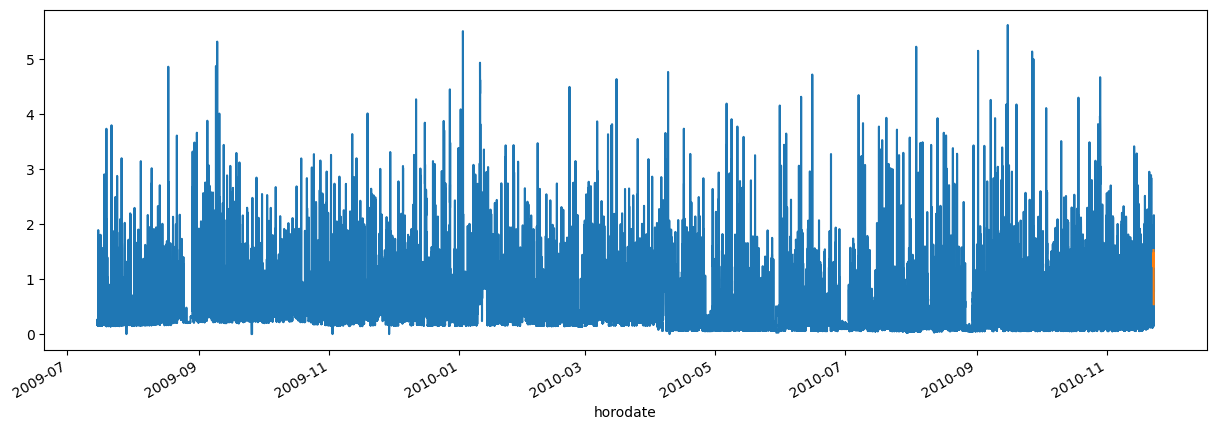

In [7]:
# Visualise the period we are trying to predict
train = conso_client_0.loc[(conso_client_0.index < date2) | ((conso_client_0.index < date4) & (conso_client_0.index >= date3))]
test = conso_client_0.loc[(conso_client_0.index >= date2) & (conso_client_0.index < date3)]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')

In [8]:
# Create the features that will be tested
def create_features(df, temp=temperatures):
  df = df.copy()
  df = df.to_frame()
  df = df.rename(columns={df.columns[0]: 'puissance_W'})
  temp = temp.set_index('horodate')


  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['temperature'] = temp.loc[df.index, 'temperature']

  df['power_24_hrs_lag'] = df['puissance_W'].shift(48)
  df['power_1_week'] = df['puissance_W'].shift(336)
  df['power_6_hrs_mean'] = df['puissance_W'].rolling(window = 12).mean()
  df['power_6_hrs_std'] = df['puissance_W'].rolling(window = 12).std()
  df['temp_24hrs_lag'] = df['temperature'].shift(48)
  df['temp_1_week'] = df['temperature'].shift(336)
  return df

In [10]:
# Prepare an input for training our model
df = create_features(conso_client_0)
df = df.rename(columns={df.columns[0]: 'puissance_W'})
df = df[df.index<date4]
df.dropna(axis=0, how='any', inplace=True)

In [11]:
train = create_features(train)
test = create_features(test)

# Selection of desired features
FEATURES = ['hour', 'dayofweek', 'month', 'dayofyear', 'temperature', 'power_24_hrs_lag', 'power_1_week', 'temp_24hrs_lag', 'temp_1_week']
TARGET = 'puissance_W'

In [12]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [13]:
reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)

[0]	validation_0-rmse:0.56749	validation_1-rmse:0.80551
[50]	validation_0-rmse:0.51827	validation_1-rmse:0.68253
[100]	validation_0-rmse:0.49549	validation_1-rmse:0.65898
[150]	validation_0-rmse:0.48255	validation_1-rmse:0.61971
[200]	validation_0-rmse:0.47360	validation_1-rmse:0.58881
[250]	validation_0-rmse:0.46592	validation_1-rmse:0.56393
[300]	validation_0-rmse:0.46051	validation_1-rmse:0.55661
[350]	validation_0-rmse:0.45612	validation_1-rmse:0.55691
[400]	validation_0-rmse:0.45176	validation_1-rmse:0.53388
[450]	validation_0-rmse:0.44826	validation_1-rmse:0.45952
[500]	validation_0-rmse:0.44456	validation_1-rmse:0.37659
[550]	validation_0-rmse:0.44154	validation_1-rmse:0.37357
[600]	validation_0-rmse:0.43941	validation_1-rmse:0.36754
[650]	validation_0-rmse:0.43741	validation_1-rmse:0.36644
[700]	validation_0-rmse:0.43494	validation_1-rmse:0.36574
[750]	validation_0-rmse:0.43257	validation_1-rmse:0.36888
[800]	validation_0-rmse:0.43042	validation_1-rmse:0.36580
[850]	validation_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

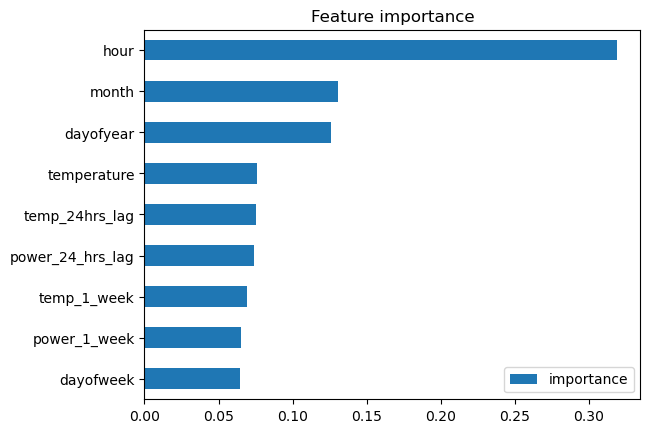

In [14]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature importance')
plt.show()

Text(0.5, 1.0, 'Raw data and prediction')

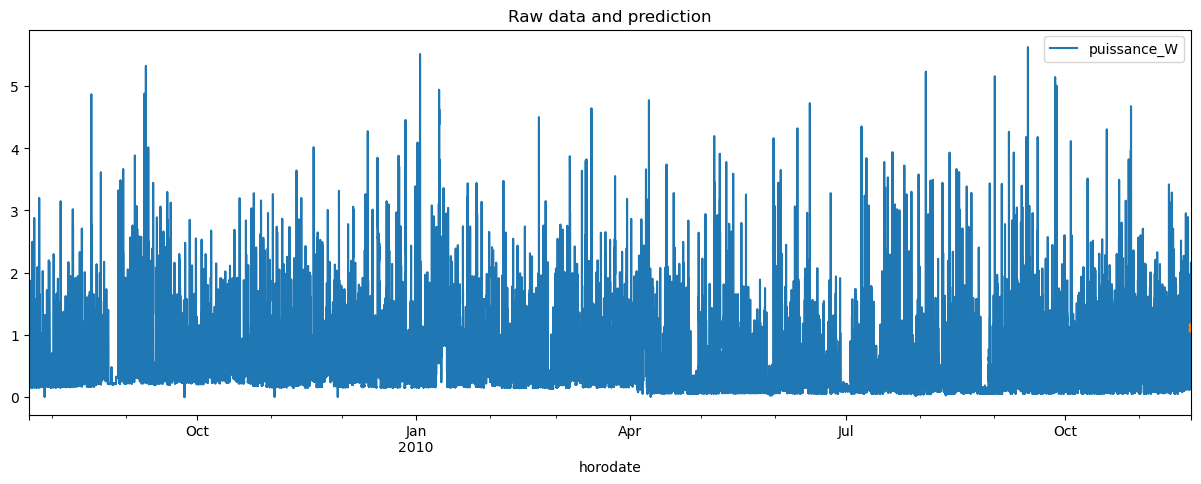

In [15]:
# Visualize prediction (better next cell)
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = df[['puissance_W']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
ax.set_title('Raw data and prediction')

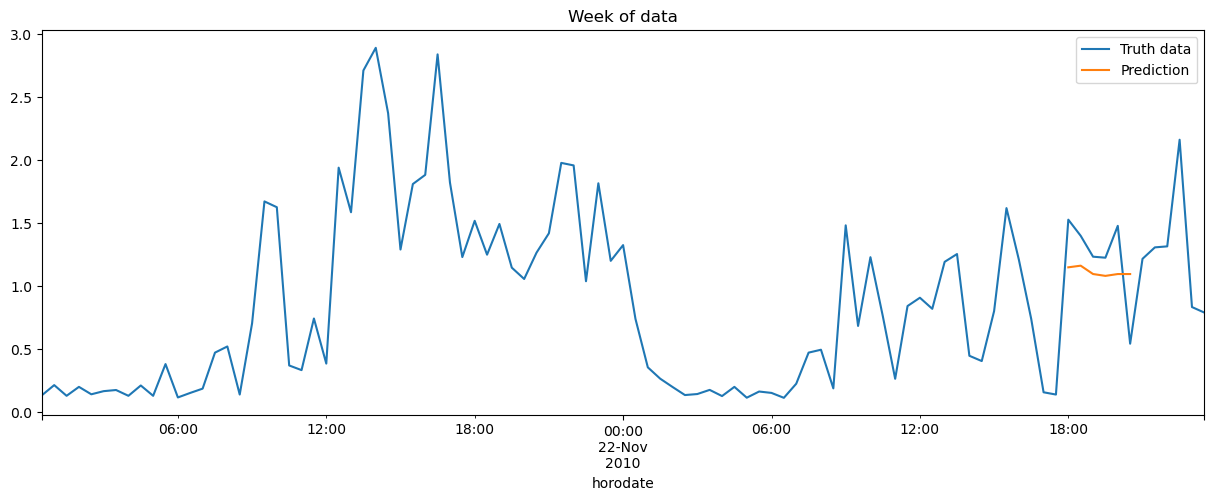

In [16]:
# Visualize
ax = df.loc[(df.index > date1) & (df.index <= date4)]['puissance_W'].plot(figsize=(15,5), title='Week of data')
df.loc[(df.index >= date2) & (df.index < date3)]['prediction'].plot(style='-')
plt.legend(['Truth data', 'Prediction'])
plt.show()

## Create pipeline to use our model easily

In [17]:
def create_train_test_set(id_client, conso_client=conso_client):
  # get the time_serie of the client
  conso_client_0 = conso_client[id_client]
  conso_client_0 = conso_client_0.rename('puissance_W')
  conso_client_0.index

  # build the train and test dataset
  train = conso_client_0.loc[(conso_client_0.index < date2) | ((conso_client_0.index < date4) & (conso_client_0.index >= date3))]
  test = conso_client_0.loc[(conso_client_0.index >= date2) & (conso_client_0.index < date3)]

  # create features on the datasets
  train = create_features(train)
  test = create_features(test)

  FEATURES = ['dayofweek', 'dayofyear', 'temperature', 'power_24_hrs_lag', 'power_1_week', 'temp_24hrs_lag', 'temp_1_week', 'hour']
  TARGET = 'puissance_W'

  X_train = train[FEATURES]
  y_train = train[TARGET]

  X_test = test[FEATURES]
  y_test = test[TARGET]

  return X_train, y_train, X_test, y_test


In [23]:
def pipeline_xgboost(id_client, conso_client=conso_client,n_estimators=100, learning_rate=0.05, verbose=10, date1=date1, date2=date2, date3=date3, date4=date4):
  # Create train and test sets
  X_train, y_train, X_test, y_test = create_train_test_set(id_client, conso_client)

  # create and fit model
  reg = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate) #early_stopping_round=500
  reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=verbose)

  # plot importance of features
  fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
  fi.sort_values('importance').plot(kind='barh', title='Feature importance')
  plt.show()

  # plot real and predict
  df = conso_client[id_client]
  df = create_features(df)
  df.dropna(axis=0, how='any', inplace=True)
  df = df[df.index<date4]
  y_pred = reg.predict(X_test)
  test['prediction'] = y_pred
  df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

  ax = df.loc[(df.index > date1) & (df.index <= date4)]['puissance_W'].plot(figsize=(15,5), title='Week of data')
  df.loc[(df.index >= date2) & (df.index < date3)]['prediction'].plot(style='-')
  plt.legend(['Truth data', 'Prediction'])
  plt.show()

  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  print(f"RMSE: {rmse}")
  return rmse

[0]	validation_0-rmse:0.60671	validation_1-rmse:0.82794
[100]	validation_0-rmse:0.50332	validation_1-rmse:0.66462
[200]	validation_0-rmse:0.48162	validation_1-rmse:0.65269
[300]	validation_0-rmse:0.46988	validation_1-rmse:0.66348
[400]	validation_0-rmse:0.46210	validation_1-rmse:0.66798
[500]	validation_0-rmse:0.45487	validation_1-rmse:0.65690
[600]	validation_0-rmse:0.44844	validation_1-rmse:0.65375
[700]	validation_0-rmse:0.44107	validation_1-rmse:0.64894
[800]	validation_0-rmse:0.43370	validation_1-rmse:0.64826
[900]	validation_0-rmse:0.42668	validation_1-rmse:0.64838
[999]	validation_0-rmse:0.41974	validation_1-rmse:0.64263


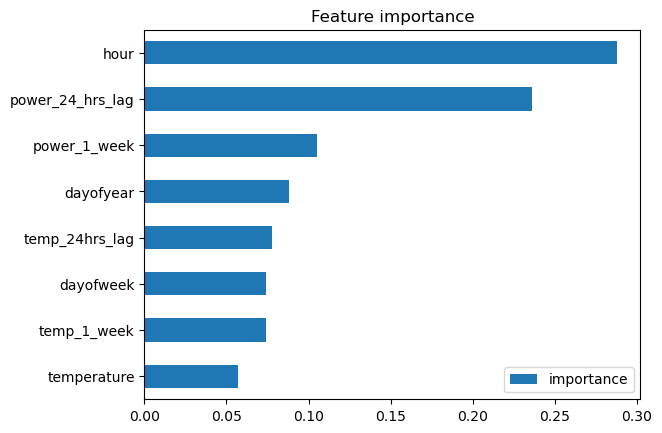

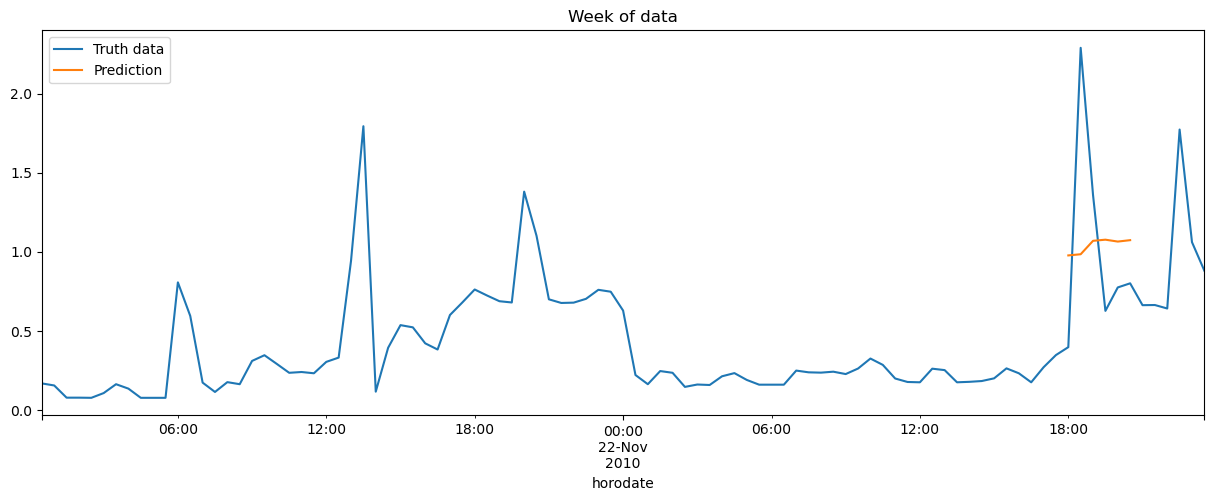

RMSE: 0.6426303505793494
[0]	validation_0-rmse:0.52347	validation_1-rmse:0.16093
[100]	validation_0-rmse:0.43483	validation_1-rmse:0.15011
[200]	validation_0-rmse:0.41745	validation_1-rmse:0.18190
[300]	validation_0-rmse:0.41056	validation_1-rmse:0.43832
[400]	validation_0-rmse:0.40519	validation_1-rmse:0.53404
[500]	validation_0-rmse:0.40039	validation_1-rmse:0.66162
[600]	validation_0-rmse:0.39612	validation_1-rmse:0.71950
[700]	validation_0-rmse:0.39047	validation_1-rmse:0.83373
[800]	validation_0-rmse:0.38578	validation_1-rmse:0.93303
[900]	validation_0-rmse:0.38170	validation_1-rmse:0.98408
[999]	validation_0-rmse:0.37822	validation_1-rmse:1.02801


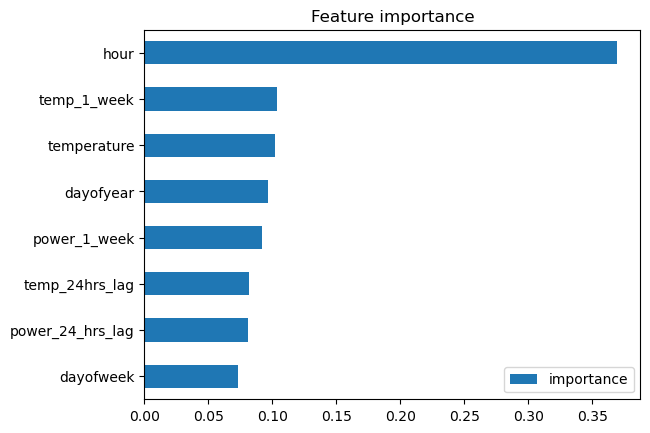

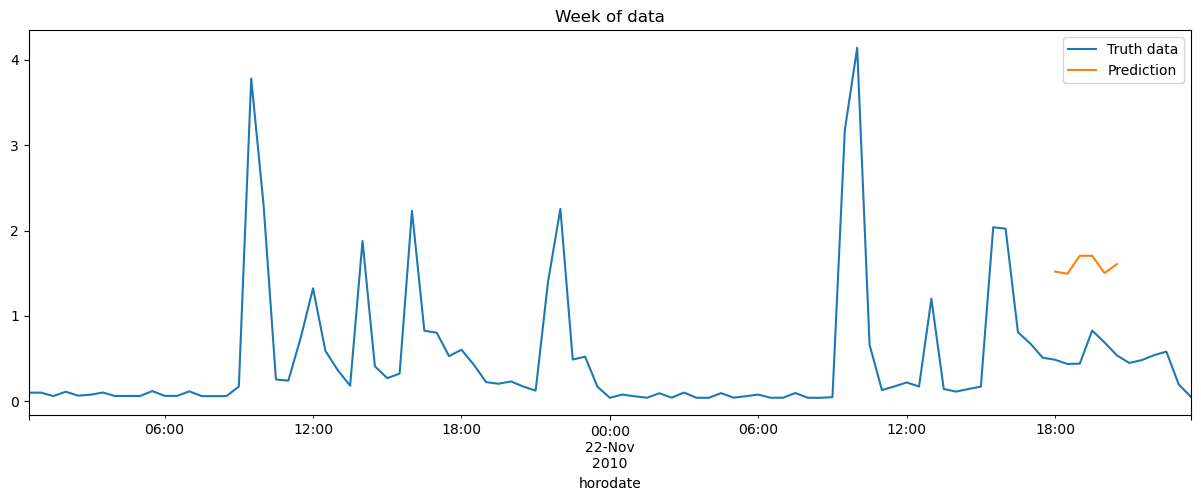

RMSE: 1.0280132583514916
[0]	validation_0-rmse:0.41411	validation_1-rmse:0.59955
[100]	validation_0-rmse:0.21872	validation_1-rmse:0.66588
[200]	validation_0-rmse:0.19647	validation_1-rmse:0.60750
[300]	validation_0-rmse:0.19148	validation_1-rmse:0.58663
[400]	validation_0-rmse:0.18812	validation_1-rmse:0.58108
[500]	validation_0-rmse:0.18503	validation_1-rmse:0.58940
[600]	validation_0-rmse:0.18218	validation_1-rmse:0.59405
[700]	validation_0-rmse:0.17959	validation_1-rmse:0.60149
[800]	validation_0-rmse:0.17649	validation_1-rmse:0.60618
[900]	validation_0-rmse:0.17415	validation_1-rmse:0.61470
[999]	validation_0-rmse:0.17174	validation_1-rmse:0.61366


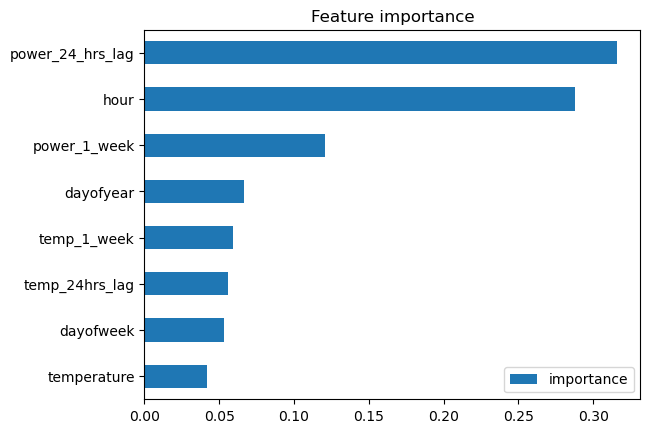

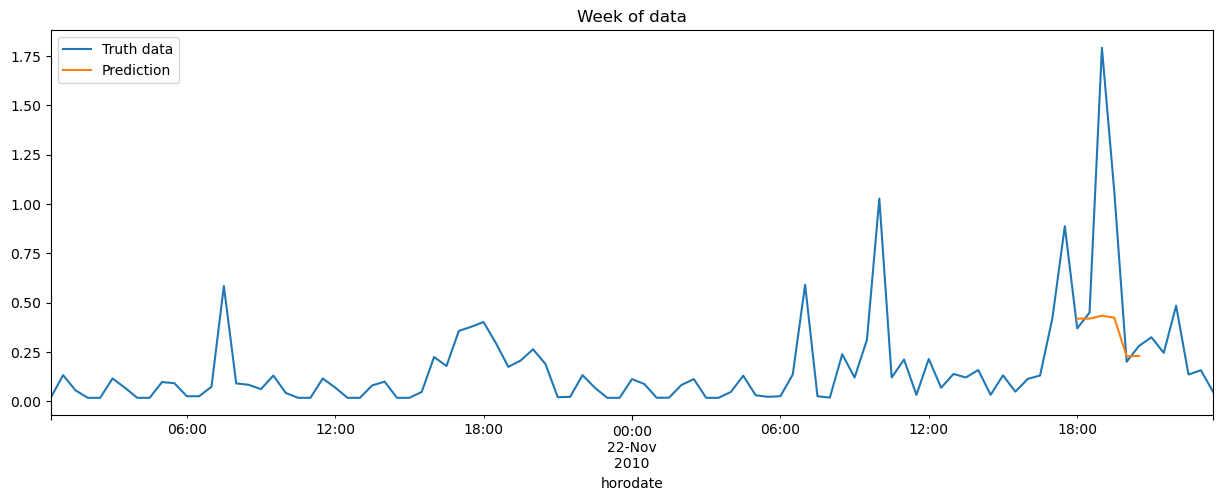

RMSE: 0.6136562097208286
[0]	validation_0-rmse:0.39699	validation_1-rmse:0.09041
[100]	validation_0-rmse:0.32775	validation_1-rmse:0.10048
[200]	validation_0-rmse:0.30853	validation_1-rmse:0.10429
[300]	validation_0-rmse:0.29764	validation_1-rmse:0.50780
[400]	validation_0-rmse:0.29130	validation_1-rmse:0.54646
[500]	validation_0-rmse:0.28514	validation_1-rmse:0.57221
[600]	validation_0-rmse:0.27916	validation_1-rmse:0.60473
[700]	validation_0-rmse:0.27414	validation_1-rmse:0.62360
[800]	validation_0-rmse:0.26871	validation_1-rmse:0.66045
[900]	validation_0-rmse:0.26442	validation_1-rmse:0.67544
[999]	validation_0-rmse:0.25990	validation_1-rmse:0.70129


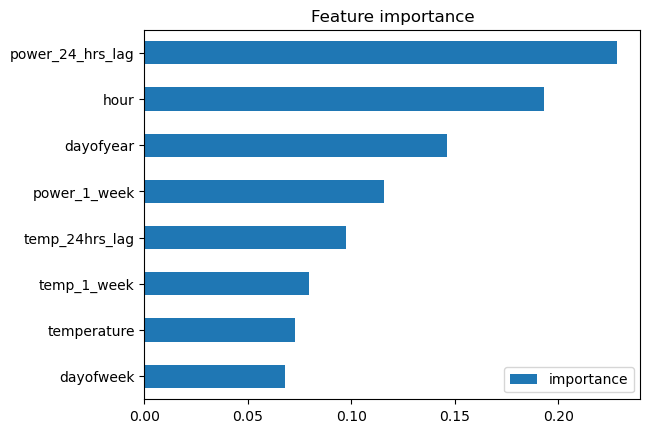

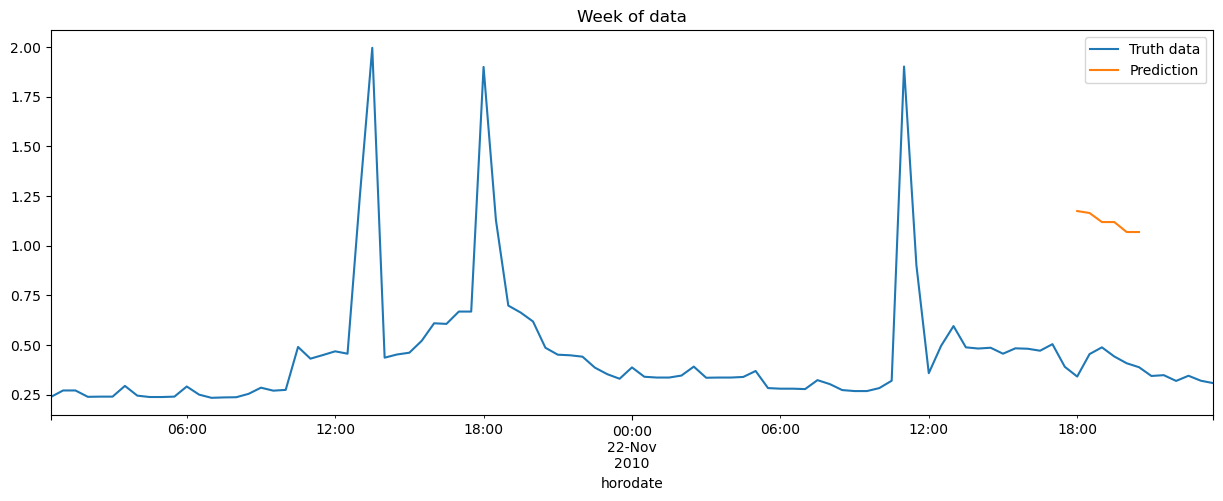

RMSE: 0.7012902019107263
[0]	validation_0-rmse:0.45223	validation_1-rmse:0.29926
[100]	validation_0-rmse:0.36435	validation_1-rmse:0.29439
[200]	validation_0-rmse:0.34577	validation_1-rmse:0.32754
[300]	validation_0-rmse:0.33673	validation_1-rmse:0.31373
[400]	validation_0-rmse:0.33121	validation_1-rmse:0.33686
[500]	validation_0-rmse:0.32403	validation_1-rmse:0.36189
[600]	validation_0-rmse:0.31762	validation_1-rmse:0.37814
[700]	validation_0-rmse:0.31224	validation_1-rmse:0.39130
[800]	validation_0-rmse:0.30722	validation_1-rmse:0.40821
[900]	validation_0-rmse:0.30251	validation_1-rmse:0.39764
[999]	validation_0-rmse:0.29761	validation_1-rmse:0.40548


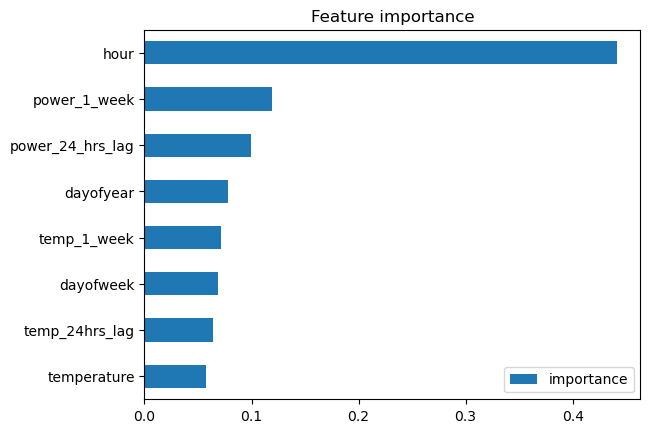

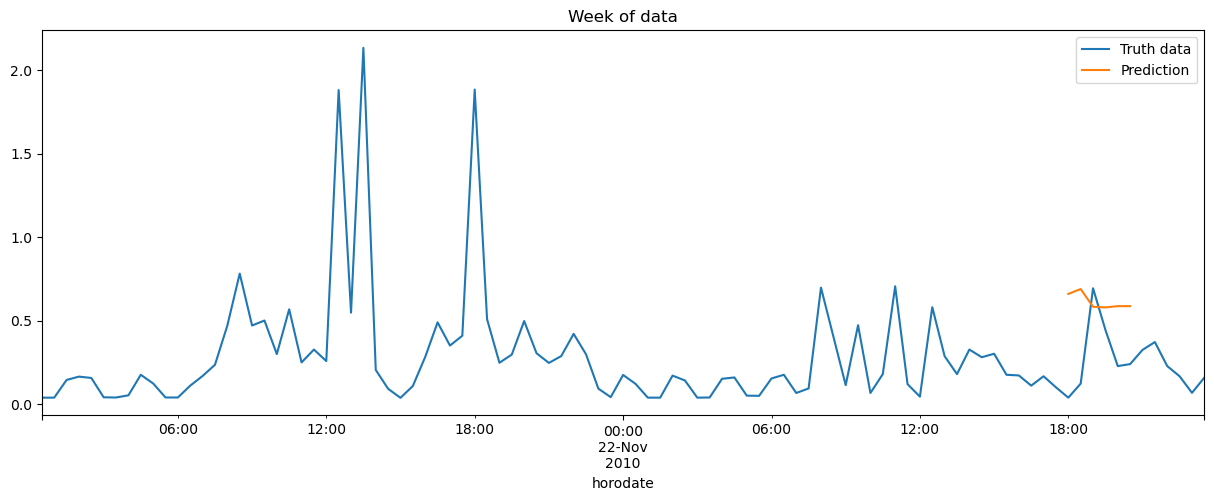

RMSE: 0.40547807417604415
Mean of rmse calculated: 0.678213618947688


In [27]:
list_rmse = []
for i in range(5):
    list_rmse.append(pipeline_xgboost(all_clients[i*41+2], n_estimators=1000, learning_rate=0.015, verbose=100))
print(f'Mean of rmse calculated: {mean(list_rmse)}')

## Pipeline using the optuna optimization library

In [29]:
# Define the objective function to be minimized
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'verbosity': 0,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    # Create and train the XGBoost model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the root mean squared error
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return rmse


In [30]:
# Let's test it on the previous train and test sets
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print the best hyperparameters and their corresponding RMSE
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-21 11:06:28,823] A new study created in memory with name: no-name-f2bd2788-4387-46d5-9610-04ef71642f44
[I 2024-04-21 11:06:33,824] Trial 0 finished with value: 0.6567226930939399 and parameters: {'max_depth': 3, 'learning_rate': 0.0036611256344492404, 'n_estimators': 486, 'subsample': 0.8919486383881019, 'colsample_bytree': 0.8460123365011385, 'min_child_weight': 3}. Best is trial 0 with value: 0.6567226930939399.
[I 2024-04-21 11:06:52,065] Trial 1 finished with value: 0.3582406023578938 and parameters: {'max_depth': 6, 'learning_rate': 0.05102319616584543, 'n_estimators': 742, 'subsample': 0.8822781546463727, 'colsample_bytree': 0.9167947736152533, 'min_child_weight': 5}. Best is trial 1 with value: 0.3582406023578938.
[I 2024-04-21 11:07:19,703] Trial 2 finished with value: 0.3720157932920699 and parameters: {'max_depth': 10, 'learning_rate': 0.017075619389661414, 'n_estimators': 852, 'subsample': 0.6502147164063639, 'colsample_bytree': 0.6701528140015001, 'min_child_weig

Best trial:
  Value: 0.3582406023578938
  Params: 
    max_depth: 6
    learning_rate: 0.05102319616584543
    n_estimators: 742
    subsample: 0.8822781546463727
    colsample_bytree: 0.9167947736152533
    min_child_weight: 5


In [32]:
# To limit the noisy outputs
optuna.logging.set_verbosity(optuna.logging.WARNING)

  0%|          | 0/10 [00:00<?, ?it/s]

Best trial: 7. Best value: 0.60101: 100%|██████████| 20/20 [02:52<00:00,  8.61s/it]


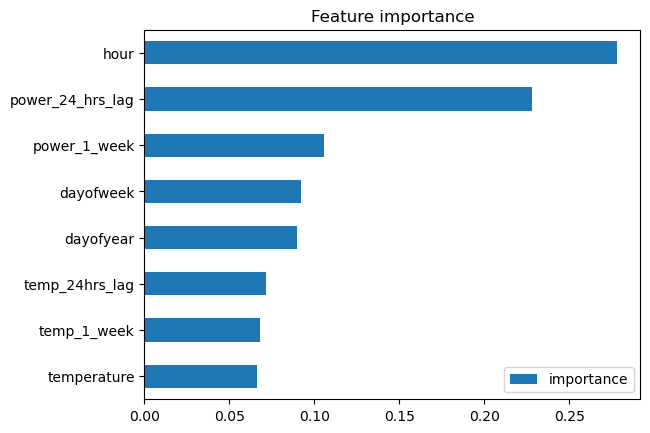

Best trial:
  Value: 0.6010095997071764
Absolute energy difference between prediction and raw: 0.12220443344116205
  Params: 
    max_depth: 8
    learning_rate: 0.04746073852106016
    n_estimators: 129
    subsample: 0.9588595067568508
    colsample_bytree: 0.7753284829157729
    min_child_weight: 7


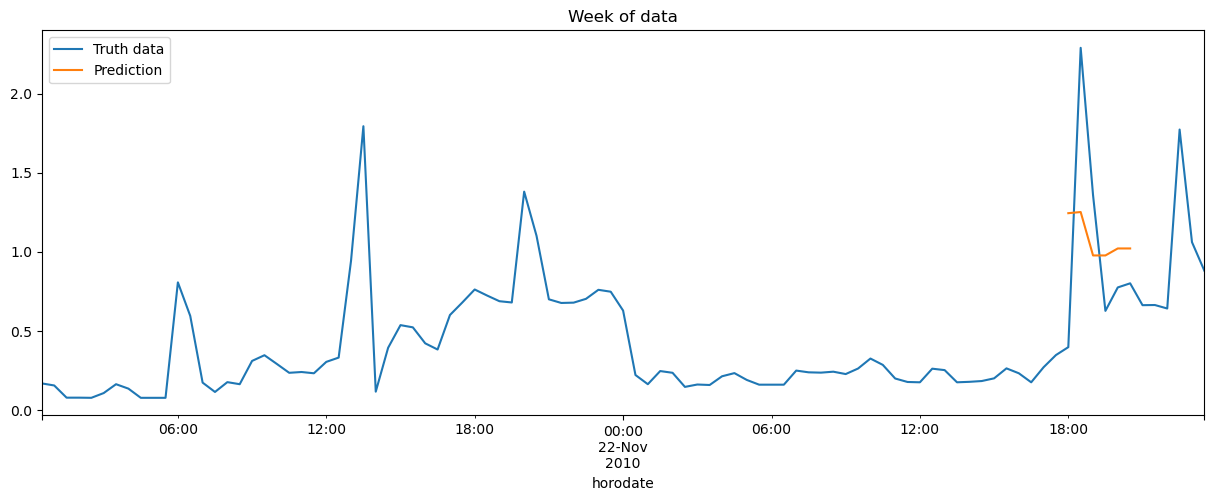

Best trial: 18. Best value: 0.212684: 100%|██████████| 20/20 [02:49<00:00,  8.48s/it]


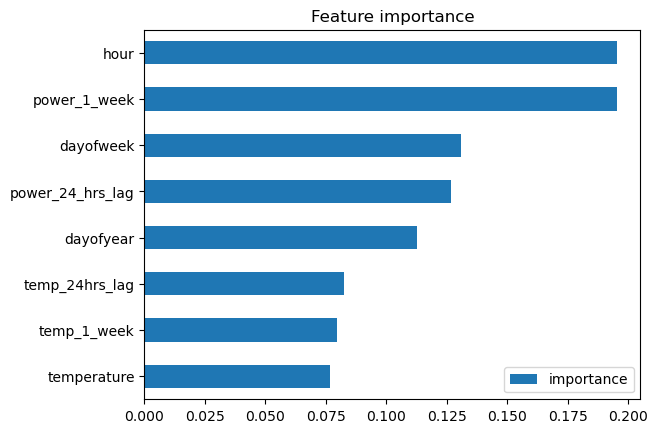

Best trial:
  Value: 0.2126840068902606
Absolute energy difference between prediction and raw: 0.010910163879394474
  Params: 
    max_depth: 10
    learning_rate: 0.04121727607777242
    n_estimators: 803
    subsample: 0.7167831480028021
    colsample_bytree: 0.9809893984713731
    min_child_weight: 10


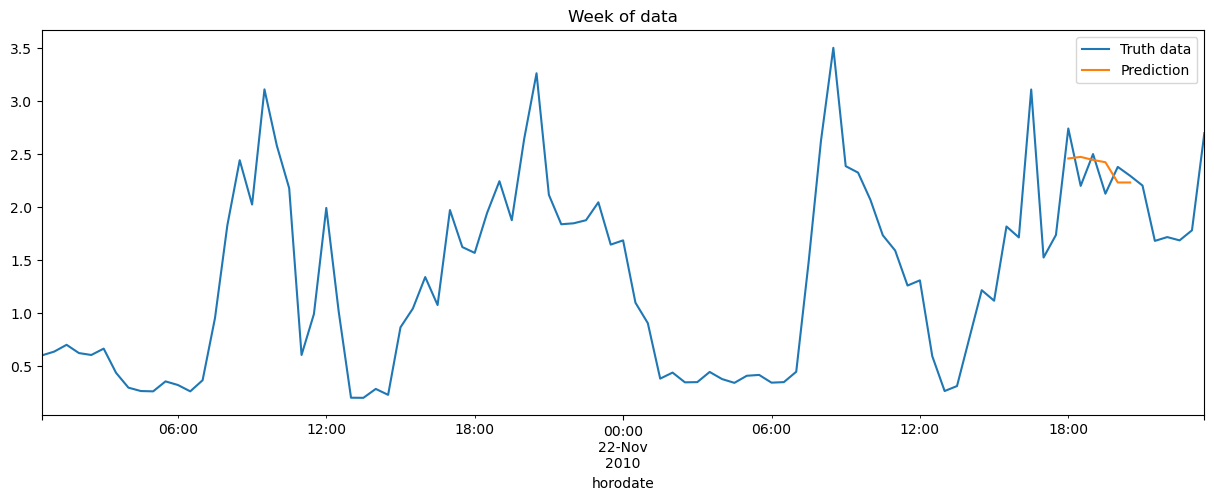

Best trial: 16. Best value: 0.167682: 100%|██████████| 20/20 [02:34<00:00,  7.73s/it]


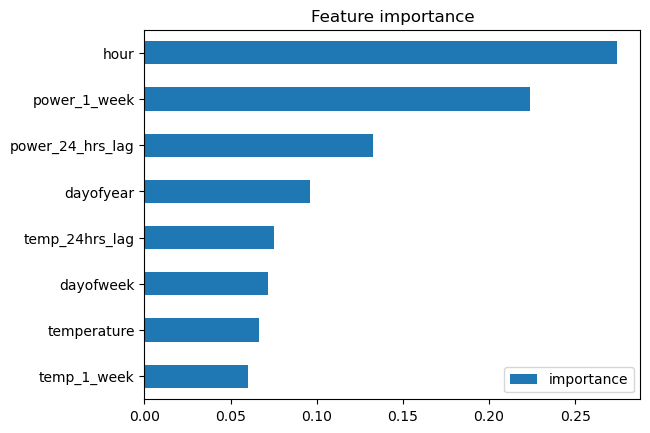

Best trial:
  Value: 0.16768204807210582
Absolute energy difference between prediction and raw: 0.013033922195434755
  Params: 
    max_depth: 10
    learning_rate: 0.001859004950403701
    n_estimators: 151
    subsample: 0.7296853654520719
    colsample_bytree: 0.6697701148650339
    min_child_weight: 4


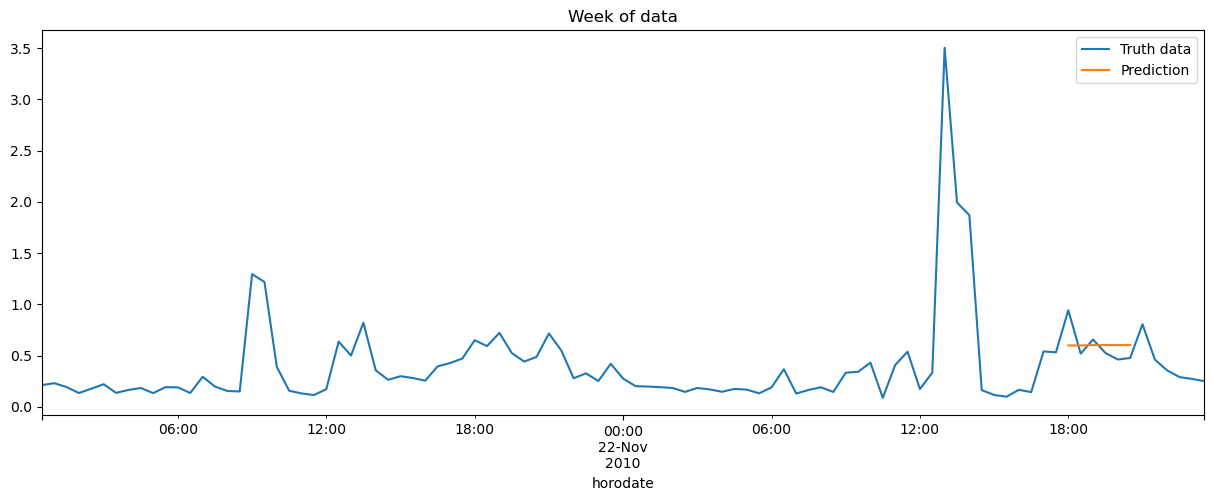

Best trial: 1. Best value: 0.549631: 100%|██████████| 20/20 [03:02<00:00,  9.11s/it]


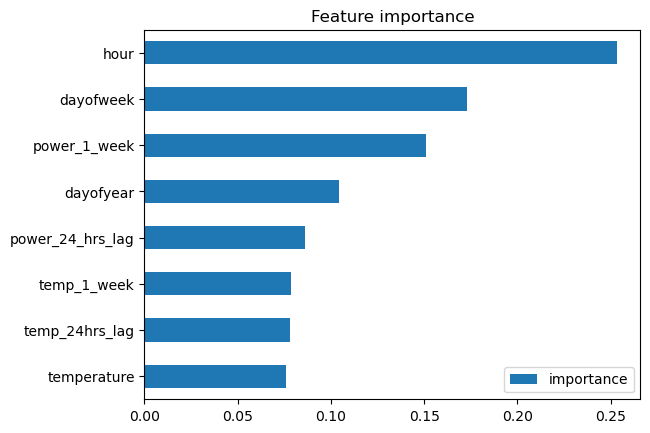

Best trial:
  Value: 0.5496312209021976
Absolute energy difference between prediction and raw: 0.35524542999267616
  Params: 
    max_depth: 10
    learning_rate: 0.06894438651045628
    n_estimators: 758
    subsample: 0.9820801963549947
    colsample_bytree: 0.9204967825890805
    min_child_weight: 8


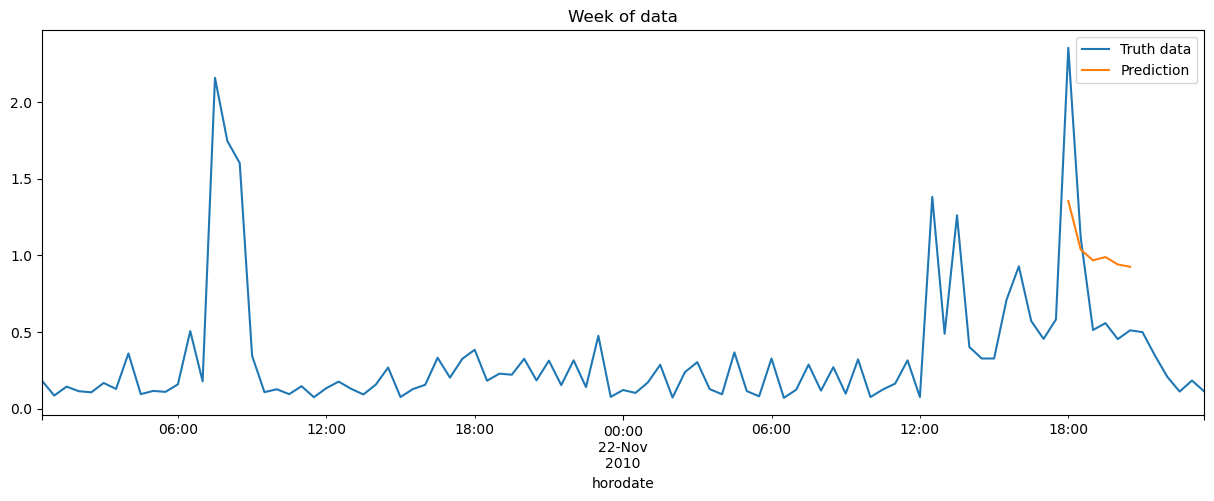

Best trial: 15. Best value: 0.667717: 100%|██████████| 20/20 [02:03<00:00,  6.18s/it]


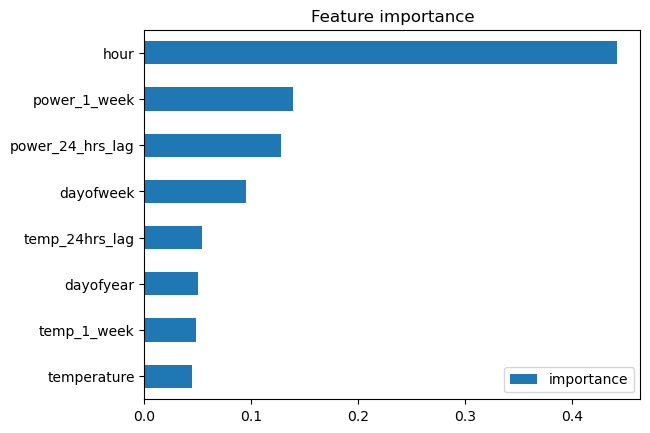

Best trial:
  Value: 0.6677172751217049
Absolute energy difference between prediction and raw: 0.006819564819335433
  Params: 
    max_depth: 3
    learning_rate: 0.09639295998625291
    n_estimators: 974
    subsample: 0.8268717455621019
    colsample_bytree: 0.6680146362014381
    min_child_weight: 2


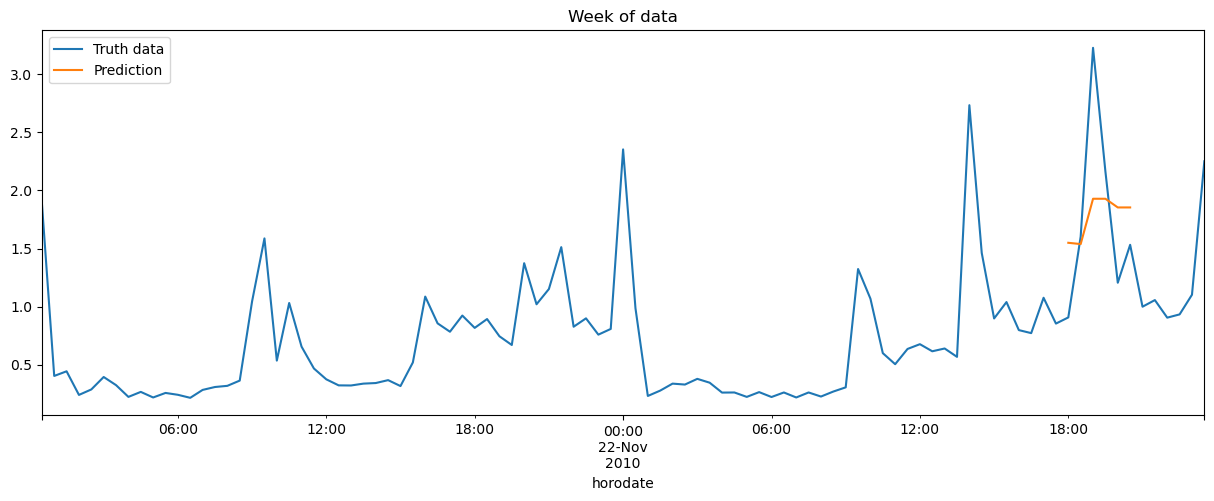

Best trial: 11. Best value: 0.138258: 100%|██████████| 20/20 [01:53<00:00,  5.68s/it]


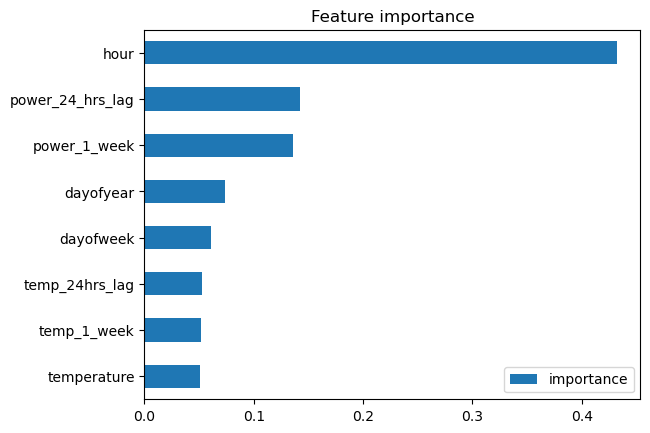

Best trial:
  Value: 0.13825813275871046
Absolute energy difference between prediction and raw: 0.04149200534820552
  Params: 
    max_depth: 5
    learning_rate: 0.003103707293920251
    n_estimators: 155
    subsample: 0.6045670386023498
    colsample_bytree: 0.5306420462382694
    min_child_weight: 8


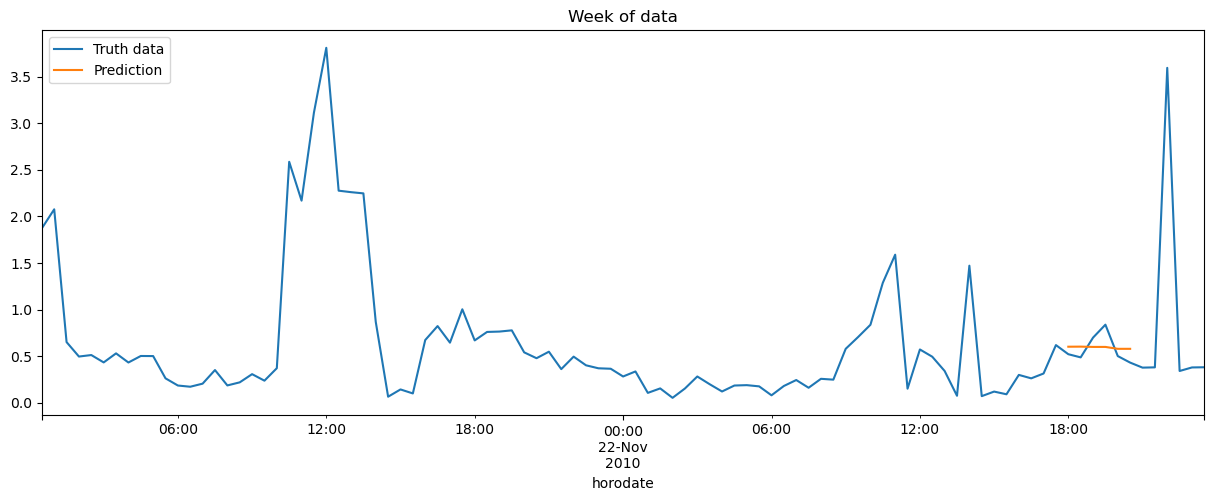

Best trial: 17. Best value: 0.328239: 100%|██████████| 20/20 [01:45<00:00,  5.25s/it]


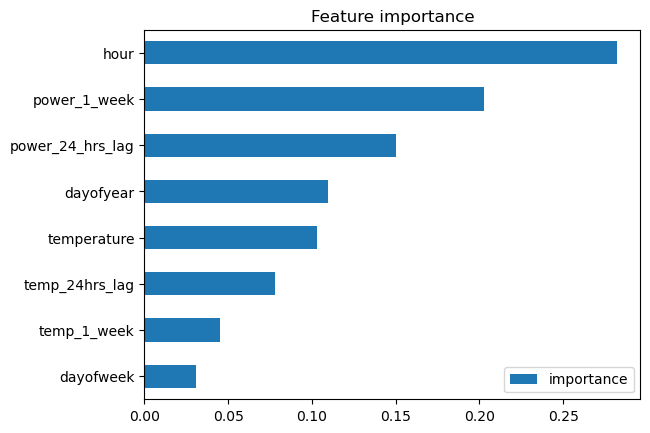

Best trial:
  Value: 0.3282389162330761
Absolute energy difference between prediction and raw: 0.01964184951782233
  Params: 
    max_depth: 4
    learning_rate: 0.004769561800948947
    n_estimators: 227
    subsample: 0.8857989150752409
    colsample_bytree: 0.577535947885623
    min_child_weight: 6


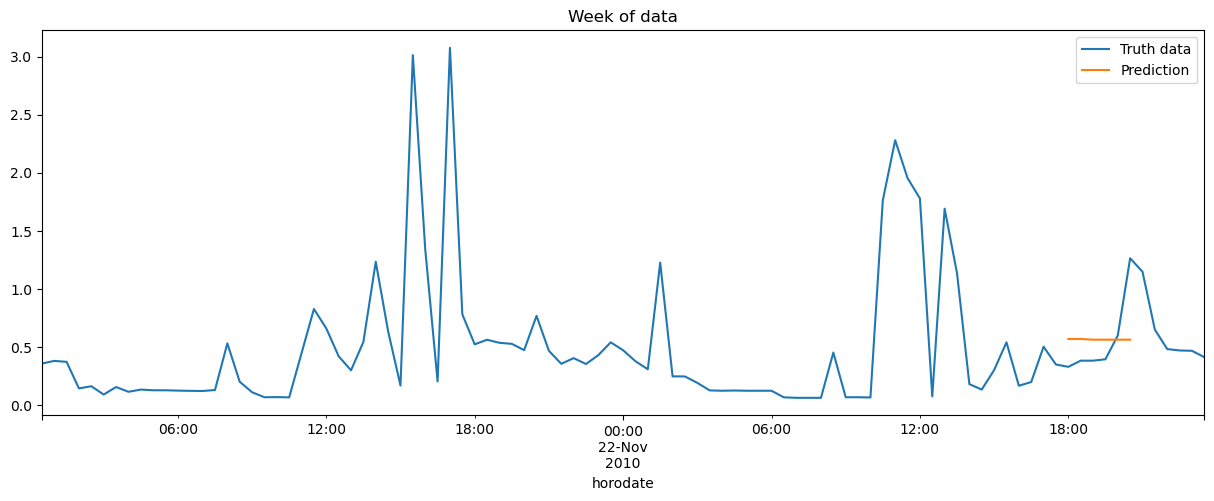

Best trial: 15. Best value: 0.226243: 100%|██████████| 20/20 [02:31<00:00,  7.55s/it]


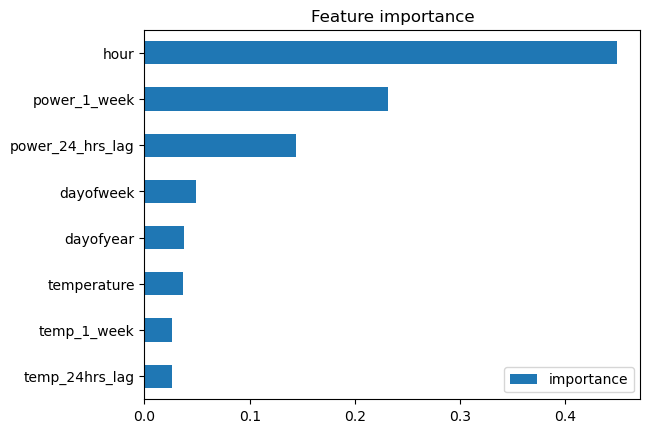

Best trial:
  Value: 0.22624253967278862
Absolute energy difference between prediction and raw: 0.019840045928955163
  Params: 
    max_depth: 4
    learning_rate: 0.0010110251250868767
    n_estimators: 962
    subsample: 0.9829748231246178
    colsample_bytree: 0.5075445569782522
    min_child_weight: 4


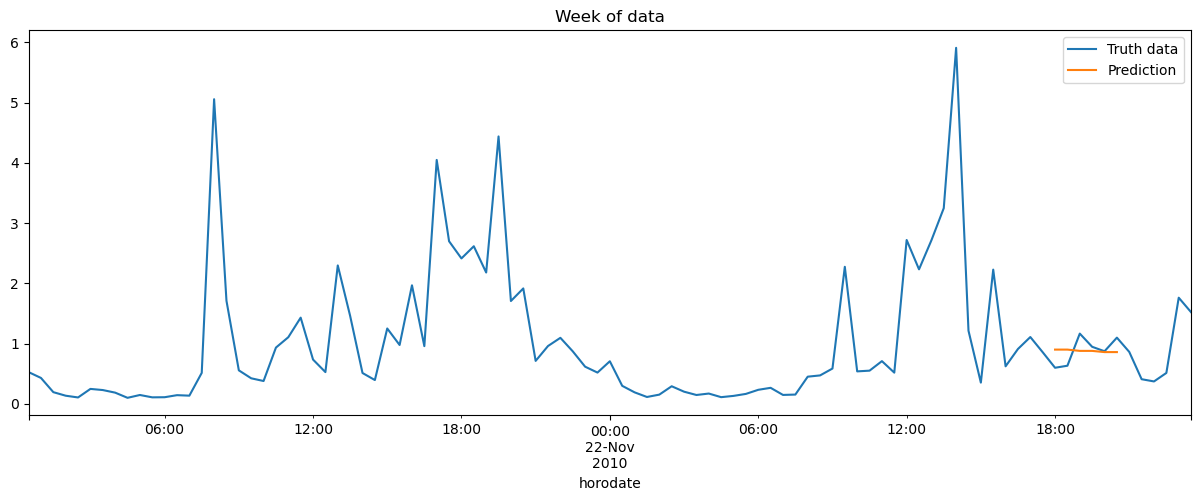

Best trial: 12. Best value: 0.138737: 100%|██████████| 20/20 [03:36<00:00, 10.82s/it]


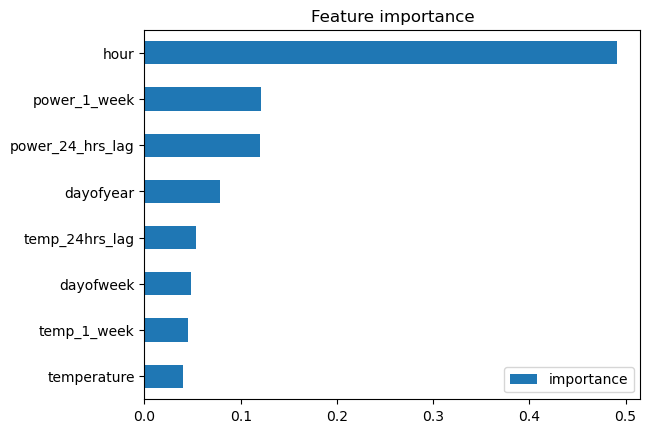

Best trial:
  Value: 0.13873732588564996
Absolute energy difference between prediction and raw: 0.03936359786987298
  Params: 
    max_depth: 3
    learning_rate: 0.06258513138489374
    n_estimators: 955
    subsample: 0.90554087553353
    colsample_bytree: 0.7358271456080727
    min_child_weight: 2


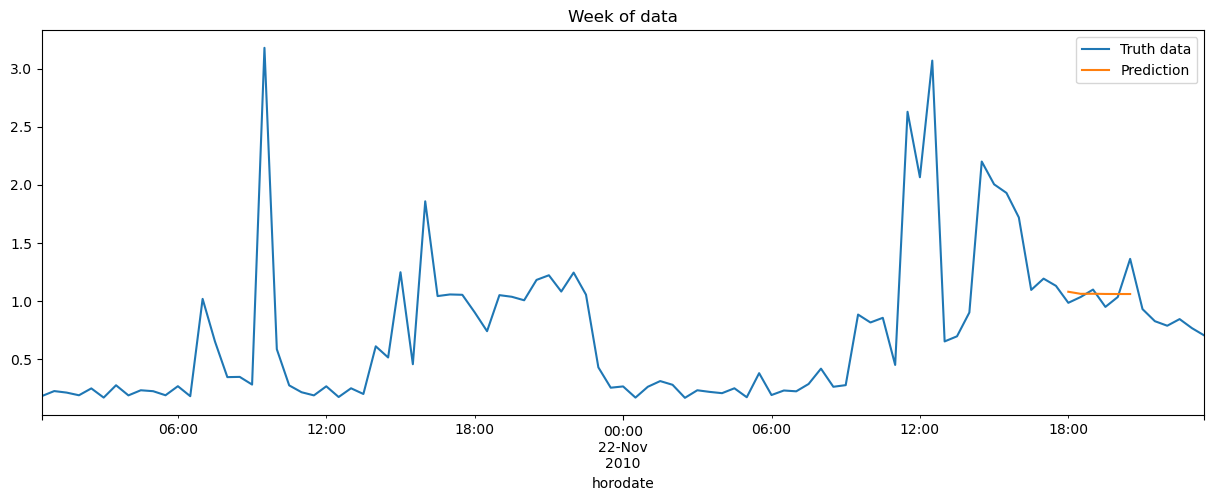

Best trial: 16. Best value: 0.0729059: 100%|██████████| 20/20 [03:09<00:00,  9.46s/it]


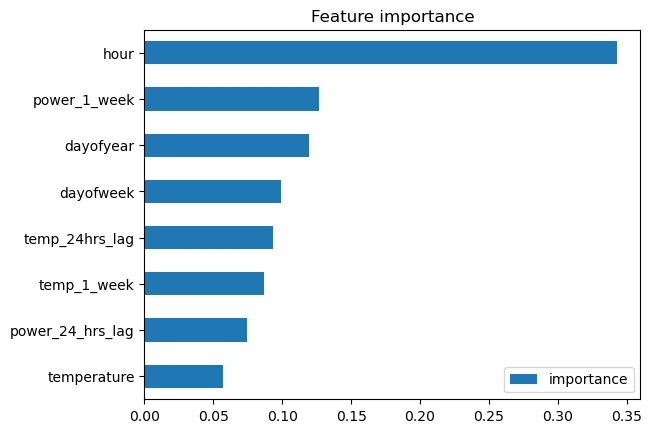

Best trial:
  Value: 0.07290585605798677
Absolute energy difference between prediction and raw: 0.017463671684265103
  Params: 
    max_depth: 10
    learning_rate: 0.0014245178898229464
    n_estimators: 477
    subsample: 0.6690030228634777
    colsample_bytree: 0.7736798821848104
    min_child_weight: 1


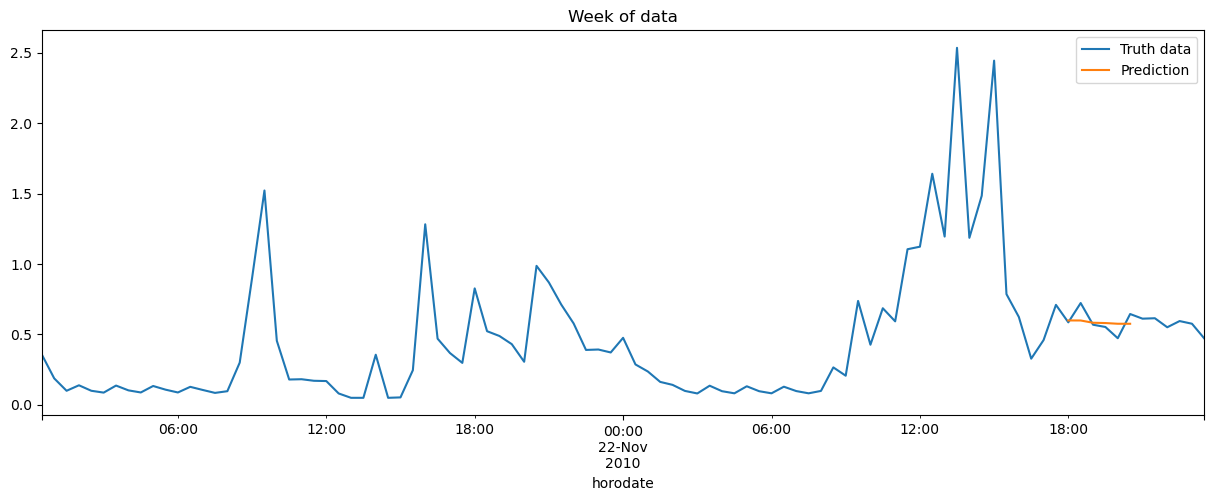

100%|██████████| 10/10 [27:57<00:00, 167.80s/it]

Moyenne des rmse:  0.3103106921301657  moyenne des écarts d'énergie:  0.06460146846771239


In [33]:
from re import VERBOSE
rmse = []
delta_J = []
# this will output all prediction for clients in the loop (there are 615 clients)
# One iteration of the loop is about 5 minutes so I'd recommend not to be too ambitious at the beginning
for i in tqdm(range(2,52,5)):
  X_train, y_train, X_test, y_test = create_train_test_set(all_clients[i])

  study = optuna.create_study(direction='minimize')
  study.optimize(objective, n_trials=20, n_jobs=-1, show_progress_bar=True)

  # Access the best trial
  best_trial = study.best_trial

  # Retrieve the optimal hyperparameters
  optimal_params = best_trial.params

  # Create the final XGBoost model with optimal hyperparameters
  final_model = xgb.XGBRegressor(**optimal_params, n_jobs=-1)

  # Train the final model on the full training dataset
  final_model.fit(X_train, y_train)

  # Assuming X_test_new is your new, unseen data
  y_pred = final_model.predict(X_test)

  # Compute the difference in energy
  delta_energy = abs(np.sum(y_pred) - np.sum(y_test)) / 2

  # plot importance of features
  fi = pd.DataFrame(data=final_model.feature_importances_,
                  index=final_model.feature_names_in_,
                  columns=['importance'])
  fi.sort_values('importance').plot(kind='barh', title='Feature importance')
  plt.show()

  # plot real and predict
  df = create_features(conso_client[all_clients[i]])
  df = df.rename(columns={df.columns[0]: 'puissance_W'})
  df = df[df.index<date4]
  test['prediction'] = y_pred
  df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

  # Print the best hyperparameters and their corresponding RMSE
  print("Best trial:")
  trial = study.best_trial
  print("  Value: {}".format(trial.value))
  print(f"Absolute energy difference between prediction and raw: {delta_energy}")
  print("  Params: ")
  rmse.append(trial.value)
  delta_J.append(delta_energy)
  for key, value in trial.params.items():
      print("    {}: {}".format(key, value))

  ax = df.loc[(df.index > date1) & (df.index <= date4)]['puissance_W'].plot(figsize=(15,5), title='Week of data')
  df.loc[(df.index >= date2) & (df.index < date3)]['prediction'].plot(style='-')
  plt.legend(['Truth data', 'Prediction'])
  plt.show()
print('Moyenne des rmse: ',mean(rmse),' moyenne des écarts d\'énergie: ', mean(delta_J))